In [72]:
!pip install -r requirements.txt

In [71]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import classification_report




In [61]:
import os

def list_folders(directory):
    folders = []
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            folders.append(item)
    return folders

# Example usage
directory_path = "CK+48"
folders_list = list_folders(directory_path)
print(folders_list)


['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']


In [62]:
# Step 1: Dataset Preparation
dataset_dir = 'CK+48'  # Path to CK+ dataset directory

# Define the list of emotions
# emotions = ['anger', 'fear', 'happy', 'sadness', 'disgust']
emotions = folders_list


# Define the image width, height, and channels
img_width = 128
img_height = 128
img_channels = 1

# Initialize empty lists to store images and labels
images = []
labels = []

# Load the images and labels
for emotion in emotions:
    emotion_dir = os.path.join(dataset_dir, emotion)
    for image_name in os.listdir(emotion_dir):
        image_path = os.path.join(emotion_dir, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (img_width, img_height))  # Resize the image
        images.append(image)
        labels.append(emotion)

# Convert the image and label lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Perform one-hot encoding on the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.from_numpy(X_train).unsqueeze(1).float()
X_test = torch.from_numpy(X_test).unsqueeze(1).float()
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)







In [63]:
# Step 2: Model Architecture (CNN)
class EmotionModel(nn.Module):
    def __init__(self, num_classes):
        super(EmotionModel, self).__init__()
        self.conv1 = nn.Conv2d(img_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * (img_width // 4) * (img_height // 4), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

model = EmotionModel(len(emotions))





In [64]:
# Step 3: Model Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
batch_size = 32
num_train_samples = X_train.shape[0]
num_batches = num_train_samples // batch_size

for epoch in range(num_epochs):
    for batch in range(num_batches):
        start = batch * batch_size
        end = start + batch_size
        inputs = X_train[start:end]
        labels = y_train[start:end]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


In [65]:
# Step 4: Model Evaluation
test_outputs = model(X_test)
_, predicted_labels = torch.max(test_outputs, 1)

predicted_labels = [emotions[label] for label in predicted_labels]
true_labels = [emotions[label] for label in y_test.numpy()]


# predicted_labels = [emotions[label] for label in predicted_labels]
# true_labels = [emotions[label] for label in y_test]
classification_metrics = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(classification_metrics)

# Step 5: Load and Process a Test Image
test_image_path = "images.jpeg"  # Provide the path to the test image
# test_image_path = "ElonMusk.jpg"  # Provide the path to the test image

# Load and preprocess the test image
test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, (img_width, img_height))
test_image = torch.from_numpy(test_image).unsqueeze(0).unsqueeze(1).float()

# Make prediction for the test image
test_output = model(test_image)
_, predicted_label = torch.max(test_output, 1)

predicted_emotion = emotions[predicted_label.item()]


Classification Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        23
    contempt       0.00      0.00      0.00         9
     disgust       0.00      0.00      0.00        43
        fear       0.00      0.00      0.00        15
       happy       0.00      0.00      0.00        43
     sadness       0.00      0.00      0.00        19
    surprise       0.23      1.00      0.37        45

    accuracy                           0.23       197
   macro avg       0.03      0.14      0.05       197
weighted avg       0.05      0.23      0.08       197



D:\internenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\internenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\internenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:

print("Predicted Emotion for the Test Image:", predicted_emotion)


Predicted Emotion for the Test Image: surprise


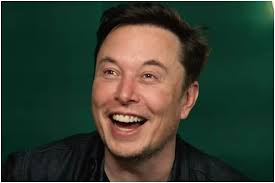